In [40]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import os
from operator import itemgetter
import json
from sklearn.feature_extraction.text import CountVectorizer

path = './/Data//Emails'
dict_path = './/Data//English Words'
name_path = './/Data//English Names'
additional_path  = './/Data//Additional'

In [41]:
train_data = pd.read_csv(os.path.join(path,'emails.train.csv'))
train_data
print(train_data.id.values)

[   0    2    3 ..., 5725 5726 5727]


In [42]:
test_data = pd.read_csv(os.path.join(path,'emails.test.csv'))
test_data
print(test_data.id.values)

[   1    7    8 ..., 5719 5721 5723]


In [43]:
train_data = pd.read_csv(os.path.join(path,'emails.train.csv'))
test_data = pd.read_csv(os.path.join(path, 'emails.test.csv'))
all_data = pd.concat([train_data, test_data])
all_data = all_data.sort_values('id')
train_indices = train_data.id.values
test_indices = test_data.id

Possible features: 
* Word frequency
 * Each element of the vector indicates frequency of respective word. Occurances divided by total words
* Length frequency
 * Each element of the vector indicates frequency of word with length i. Occurances dived by total words
* Total number of words
 * Numeric value
* Total number of letters
 * Numeric value
* Number of non-alphabet characeters in subject
* Number of non-alphabet characters in body
* Indicators in subject
 * Reply, forward ..
* Personal greeting
* Presence of personal names
* Number of grammatically incorrect words
* Number of unique words

In [44]:
#Creates dictionary of the form {word(str):number(int)} for a single piece of text
def word_split(text):
    word_dict = {}
    current_word = str()
    for i in range(len(text)):
        if text[i].isalpha():
            current_word += text[i]
            continue
        else:
            if current_word:
                if current_word in word_dict:
                    word_dict[current_word] += 1
                else:
                    word_dict[current_word] = 1
                current_word = str()
            else:
                continue
    return word_dict

#Creates a list of all words in the data set
def local_words(text_list):
    local_word_list = []
    for i in range(len(text_list)):
        text = text_list.iloc[i]
        word_dict = word_split(text)
        for word in word_dict:
            local_word_list.append(word)
    return local_word_list

#Creates a dictionary similar to word_split, but for full data set
def local_word_dict(text_list):
    local_word_dict = {}
    for i in range(len(text_list)):
        word_dict = word_split(text_list.iloc[i])
        local_word_dict = {word: local_word_dict.get(word, 0) + word_dict.get(word, 0) for word in set(local_word_dict)|set(word_dict)}
    return local_word_dict

#Returns the n most frequent words in a dictionary of the type described in word_split
def top_words(n, word_dict):
    assert n < len(word_dict)
    top_dict = {}
    sorted_keys = sorted(word_dict, key=word_dict.get, reverse=True)
    for i in range(n):
        top_dict[sorted_keys[i]] = word_dict[sorted_keys[i]]
    return top_dict
        
#Applying the functions to different subsets of the data            
emails = train_data.text
all_words = local_words(emails)

spam = train_data.text[train_data.spam > 0]
spam_words = local_words(spam)

non_spam = train_data.text[train_data.spam < 1]
non_spam_words = local_words(non_spam)

email_dict = local_word_dict(emails)

spam_dict = local_word_dict(spam)

non_spam_dict = local_word_dict(non_spam)

In [45]:
#Reading external data into files. Dictionary, names, other custom lists

english_dict_file = os.path.join(dict_path, 'words_dictionary.json')
with open(english_dict_file,"r") as english_dictionary:
    english_words_dict = json.load(english_dictionary)
english_words_set = set(english_words_dict.keys())

english_fnames_file = os.path.join(name_path, 'popular-both-first.txt')
first_names = pd.read_csv(english_fnames_file, header=None)
english_fnames_list = first_names.iloc[:, 0]
english_fnames_list = [english_fnames_list[i].lower() for i in range(len(english_fnames_list))
                      if isinstance(english_fnames_list[i], str)]
english_fname_set = set(english_fnames_list)

english_lnames_file = os.path.join(name_path, 'census-dist-2500-last.csv')
last_names = pd.read_csv(english_lnames_file, header=None)
english_lnames_list = last_names.iloc[:, 0]
english_lnames_list = [english_lnames_list[i].lower() for i in range(len(english_lnames_list))
                      if isinstance(english_lnames_list[i], str)]
english_lname_set = set(english_lnames_list)

english_greetings_file = os.path.join(additional_path, 'greetings.txt')
greetings = pd.read_csv(english_greetings_file, header=None)
greetings_list = greetings.iloc[:, 0]
greetings_set = set(greetings_list)

indicator_file = os.path.join(additional_path, 'indicators.txt')
indicators = pd.read_csv(indicator_file, header=None)
indicators_list = indicators.iloc[:, 0]
indicators_set = set(indicators_list)

date_file = os.path.join(additional_path, 'days_months.txt')
dates = pd.read_csv(indicator_file, header=None)
dates_list = indicators.iloc[:, 0]
date_set = set(indicators_list)

In [46]:
#Getting proportion of correct words
def text_dict_check(text_dict, english_dict_set):
    correct_words = 0
    incorrect_words = 0
    text_set = set(text_dict.keys())
    for word in text_set:
        if word in english_dict_set:
            correct_words += 1
    return correct_words/len(text_dict)

non_spam_prop = np.mean(np.array([text_dict_check(word_split(non_spam.iloc[i]), english_words_set)
                                  for i in range(len(non_spam))]))
spam_prop = np.mean(np.array([text_dict_check(word_split(spam.iloc[i]), english_words_set)
                              for i in range(len(spam))]))

#Check dictionary for words also in set
def personal_names_check(text_dict, english_name_set):
    personal_names = 0
    text_set = set(text_dict.keys())
    for word in text_set:
        if word in english_name_set:
            personal_names += 1
    return personal_names

In [57]:
def bag_of_words(emails):
    CV = CountVectorizer()
    return CV.fit_transform(emails).toarray()

In [58]:
#Collecting all features in a numpy array
def create_design_matrix(data, ew_set, ef_set, el_set, g_set, i_set, d_set):
    bow = bag_of_words(data.text)
    observations = len(data)
    features = 9 + bow.shape[1]
    X = np.zeros((observations, features))
    for i in range(observations):
        mail = data.text.iloc[i]
        d = word_split(mail)
        # Proportion of unique words
        X[i, 0] = len(d) / sum(d.values())
        # Proportion correct words
        X[i, 1] = text_dict_check(d, ew_set)
        # Number of personal names
        X[i, 2] = personal_names_check(d, ef_set)
        # Number of last names
        X[i, 3] = personal_names_check(d, el_set)
        # Number of greetings
        X[i, 4] = personal_names_check(d, g_set)
        # Number of indicators
        X[i, 5] = personal_names_check(d, i_set)
        # Presence of days, months, holidays
        X[i, 6] = personal_names_check(d, d_set)
        # Number of words
        X[i, 7] = sum(d.values())
        # Average word length
        av_len = 0
        for word in d:
            av_len += len(word) / sum(d.values())
        X[i, 8] = av_len
        X[i, 9:] = np.array(bow[i, :])
    return X

#Creating numpy array for response
def create_response_vector(data):
    Y = np.array(data.spam)
    Y[Y == 0] = -1
    return Y

In [59]:
X = create_design_matrix(all_data, english_words_set, english_fname_set, english_lname_set,
                         greetings_set, indicators_set, date_set)
Y = create_response_vector(all_data)

In [60]:
print(X.shape)
print(Y.shape)
     
X_train = X[train_indices.tolist(), :]
Y_train = Y[train_indices.tolist()]
X_test = X[test_indices.tolist(), :]

print(len(Y_train))

print(X_train.shape)

(5728, 37312)
(5728,)
4021
(4021, 37312)


In [ ]:
from sklearn.linear_model import LogisticRegression

def data_split(data):
    test_indices = np.random.choice(len(data), len(data)//5)
    train_indices = np.array([i for i in range(len(data)) if i not in test_indices])
    Y = create_response_vector(data)
    X = create_design_matrix(data, english_words_set, english_fname_set, english_lname_set,
                             greetings_set, indicators_set, date_set)
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = data_split(train_data)
lr = LogisticRegression().fit(X_train, Y_train)
print(lr.score(X_train, Y_train))
print(lr.score(X_test, Y_test))

In [408]:
from sklearn.svm import LinearSVC, NuSVC

X_train, X_test, Y_train, Y_test = data_split(train_data)
svm = NuSVC(nu=0.3).fit(X_train, Y_train)
print(svm.score(X_train, Y_train))
print(svm.score(X_test, Y_test))

0.947176684882
0.860696517413


In [423]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, Y_train, Y_test = data_split(train_data)
tree = DecisionTreeClassifier(max_depth=8, random_state=0)
tree.fit(X_train, Y_train)
print(tree.score(X_train, Y_train))
print(tree.score(X_test, Y_test))

0.927245053272
0.8407960199


0.991481594159
0.901741293532


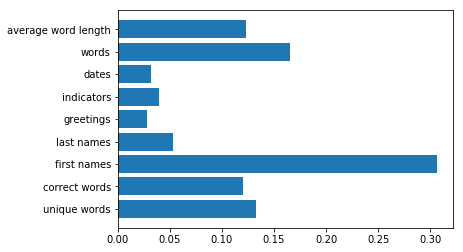

In [422]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, accuracy_score
X_train, X_test, Y_train, Y_test = data_split(train_data)

forest = RandomForestClassifier(n_estimators=10)
forest.fit(X_train, Y_train)
print(forest.score(X_train, Y_train))
print(forest.score(X_test, Y_test))

n_features = X_train.shape[1]
plt.barh(range(n_features), forest.feature_importances_, align='center')
feature_names = ['unique words', 'correct words', 'first names', 'last names', 'greetings', 'indicators',
                 'dates', 'words', 'average word length']
plt.yticks(np.arange(n_features), feature_names)
plt.show()

In [427]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=['spam', 'non-spam'], feature_names=feature_names,
                impurity=False, filled=True)
import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

ModuleNotFoundError: No module named 'graphviz'